In [1]:
import numpy as np
import tensorflow as tf
import scipy as scp
import sklearn as skl
from tqdm import tqdm
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import sklearn.metrics
from PIL import Image
import glob
import os
from tqdm import tqdm
import wave
import pylab
from pathlib import Path
import librosa
from IPython.display import Audio
import multiprocessing


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!git clone https://github.com/soerenab/AudioMNIST.git --depth=1

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30082, done.
remote: Counting objects: 100% (30082/30082), done.
remote: Compressing objects: 100% (30077/30077), done.
remote: Total 30082 (delta 5), reused 30078 (delta 5), pack-reused 0
Receiving objects: 100% (30082/30082), 944.53 MiB | 17.65 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (30018/30018), done.


In [20]:
!rm -rf spectrograms

In [28]:
# generate original spec from audio
if not os.path.exists('spectrograms'):
    os.mkdir('spectrograms')
 

for name in range(1, 20):
  INPUT_DIR = 'AudioMNIST/data/' + str(name).zfill(2)
  for filename in tqdm(os.listdir(INPUT_DIR)):
    if "wav" in filename:
      file_path = os.path.join(INPUT_DIR, filename)
      file_stem = Path(file_path).stem
      target_dir = f'class_{file_stem[0]}'
      dist_dir = os.path.join('spectrograms', target_dir)
      file_dist_path = os.path.join(dist_dir, file_stem)
      if not os.path.exists(file_dist_path + '.png'):
          if not os.path.exists(dist_dir):
              os.mkdir(dist_dir)
          
          audio_file = wave.open(file_path, mode="r")
          sampling_frequency = audio_file.getframerate()
          audio_signal = np.frombuffer(audio_file.readframes(sampling_frequency), dtype=np.int16)

          plt.specgram(audio_signal, Fs=sampling_frequency, cmap = "plasma")
          plt.savefig(f'{file_dist_path}.png')
          plt.close()


100%|██████████| 500/500 [01:06<00:00,  7.48it/s]


In [29]:
# Change image size to 128 * 128
if not os.path.exists('resized-spectrograms'):
    os.mkdir('resized-spectrograms')

for filename in tqdm(glob.glob(r"spectrograms" + '/**/*.png', recursive=True)):
    file_stem = Path(filename).stem
    target_dir = f'class_{file_stem[0]}'
    dist_dir = os.path.join('resized-spectrograms', target_dir)
    file_dist_path = os.path.join(dist_dir, file_stem)

    if not os.path.exists(file_dist_path + '.png'):
        if not os.path.exists(dist_dir):
            os.mkdir(dist_dir)
        try:
          im = Image.open(filename)
          imm = im.resize((128, 128))
          imm.save(file_dist_path + '.png')
          im.close()
          imm.close()
        except:
          print(filename)


100%|██████████| 9500/9500 [01:29<00:00, 106.16it/s]


In [2]:
import random 

image_list_ori = []
image_list_re = []

for filename in tqdm(glob.glob(r'resized-spectrograms' + '/**/*.png', recursive=True)):
  if '.png' in filename:
    ori_name1 = filename

    file_stem = Path(ori_name1).stem

    ori_name2 = ori_name1.rsplit('_', 1)[0] + "_" + str((int(file_stem.split('_')[-1]) + random.randint(10, 30)) % 60) + ".png"

    if (os.path.exists(ori_name1) and os.path.exists(ori_name2)):
      im = Image.open(ori_name2).convert('RGB')
      image_list_re.append(np.asarray(im))
      im.close()
      im = Image.open(ori_name1).convert('RGB')
      image_list_ori.append(np.asarray(im))
      im.close()
    

100%|██████████| 9500/9500 [00:15<00:00, 610.39it/s]


In [3]:
image_list_ori = np.array(image_list_ori)
image_list_re = np.array(image_list_re)

print(image_list_ori.shape)

n = len(image_list_ori)
train_data_len = int(n*0.8) # Roughly 50k images
train_data_1 = image_list_ori[:train_data_len] # getting images upto 50k index
test_data_1 = image_list_ori[train_data_len:] # getting rest of the images
train_data_2 = image_list_re[:train_data_len] # getting images upto 50k index
test_data_2 = image_list_re[train_data_len:] # getting rest of the images

train_data_1 = np.array(train_data_1)[:, :, :, 1]
test_data_1 = np.array(test_data_1)[:, :, :, 1]
train_data_2 = np.array(train_data_2)[:, :, :, 1]
test_data_2 = np.array(test_data_2)[:, :, :, 1]

train_data_1 = train_data_1.reshape(-1, 16384).astype("float32") / 255.0
test_data_1 = test_data_1.reshape(-1, 16384).astype("float32") / 255.0
train_data_2 = train_data_2.reshape(-1, 16384).astype("float32") / 255.0
test_data_2 = test_data_2.reshape(-1, 16384).astype("float32") / 255.0


(7562, 128, 128, 3)


In [4]:
def tf_unif_prior_crossentropy(pred1,pred2):
    N, C = pred1.shape 
    t_c = 0.1
    t_r = 0.1
    a = tf.nn.softmax(pred2/t_c, axis=0)
    b = tf.linalg.norm(a, ord=1,axis=1)
    # try :
    c = a/tf.reshape(b,(N,-1))
    # except :
    #     try :
    #         c = a/tf.reshape(b,(X_train.shape[0]%batch_size,-1))
    #     except :
    #         c = a/tf.reshape(b,(X_test.shape[0]%batch_size,-1))
            

    part11 = c
    d = tf.nn.softmax(pred1/t_r, axis=1)
    part21 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)), (-1,C))
    loss_1 = -tf.math.reduce_sum( part11 * part21 , axis=-1)


    a = tf.nn.softmax(pred1/t_c)
    b = tf.linalg.norm(a, ord=1,axis=1)
    c = a/tf.reshape(b,(N,-1))
    part12 = c
    d = tf.nn.softmax(pred2/t_r, axis=1)
    part22 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)),(-1,C))
    loss_2 = -tf.math.reduce_sum( part12*part22 , axis=-1)

    return tf.math.reduce_mean(1/2*(loss_1+loss_2))

In [7]:

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128 * 128), dtype=tf.float32),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10,activation = None, dtype='float32'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("softmax")
    ])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                524320    
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [8]:
import sklearn as skl
import sklearn.metrics

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

NUM_EPOCHS = 100
EPOCH_PER_DISPLAY = 1
total_loss = []
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_1, train_data_2))
train_dataset = train_dataset.shuffle(train_data_1.shape[0]).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_1, test_data_2))
test_dataset = test_dataset.shuffle(test_data_1.shape[0]).batch(64)

for epoch in range(NUM_EPOCHS):

  running_loss = []

  for input1, input2 in tqdm(train_dataset):
    with tf.GradientTape() as tape:

      pred1 = model(input1, training=True)
      pred2 = model(input2, training=True)

      loss_ = tf_unif_prior_crossentropy(pred1, pred2)

      grads = tape.gradient(loss_, model.trainable_variables)
      
    running_loss.append(loss_)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
  
  epoch_loss = np.mean(running_loss)
  if (epoch + 1) % EPOCH_PER_DISPLAY == 0:
    print("Epoch {}: Train Loss: {:.4f}".format(epoch+1, epoch_loss), end="")


  valid_loss = []
  valid_nmi = []
  valid_ami = []
  valid_ari = []
  valid_acc = []

  for input1, input2 in test_dataset:
    pred1 = model(input1, training=False)
    pred2 = model(input2, training=False)
    loss_ = tf_unif_prior_crossentropy(pred1, pred2)
    valid_loss.append(loss_)
    pred1 = pred1.numpy().argmax(axis=1)
    pred2 = pred2.numpy().argmax(axis=1)
    valid_nmi.append(skl.metrics.normalized_mutual_info_score(pred1, pred2))
    valid_ami.append(skl.metrics.adjusted_mutual_info_score(pred1, pred2))
    valid_ari.append(skl.metrics.adjusted_rand_score(pred1, pred2))
    valid_acc.append(skl.metrics.accuracy_score(pred1, pred2))
    cor_cnt = 0
    for tmp1, tmp2 in zip(pred1, pred2):
      if (tmp1 == tmp2):
        cor_cnt += 1
  print("   Valid Loss: {:.4f}    NMI: {:.4f}   AMI: {:.4f}   ARI: {:.4f}   ACC: {:.4f}".format(np.mean(valid_loss), 
                                                                                np.mean(valid_nmi), np.mean(valid_ami), 
                                                                                np.mean(valid_ari), np.mean(valid_acc), cor_cnt))

100%|██████████| 24/24 [00:02<00:00, 10.09it/s]


Epoch 1: Train Loss: 2.7973   Valid Loss: 2.3027    NMI: 0.0493   AMI: 0.0289   ARI: 0.0550   ACC: 0.9341


100%|██████████| 24/24 [00:01<00:00, 14.29it/s]


Epoch 2: Train Loss: 2.7505   Valid Loss: 2.3041    NMI: 0.0448   AMI: 0.0176   ARI: 0.0266   ACC: 0.5585


100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Epoch 3: Train Loss: 2.6886   Valid Loss: 2.3059    NMI: 0.0453   AMI: 0.0219   ARI: 0.1092   ACC: 0.7935


100%|██████████| 24/24 [00:01<00:00, 14.35it/s]


Epoch 4: Train Loss: 2.6380   Valid Loss: 2.3126    NMI: 0.0813   AMI: 0.0212   ARI: 0.0779   ACC: 0.5694


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 5: Train Loss: 2.6099   Valid Loss: 2.3155    NMI: 0.1427   AMI: 0.0849   ARI: 0.1442   ACC: 0.5776


100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Epoch 6: Train Loss: 2.5939   Valid Loss: 2.3129    NMI: 0.2282   AMI: 0.1558   ARI: 0.2566   ACC: 0.6819


100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Epoch 7: Train Loss: 2.5655   Valid Loss: 2.3259    NMI: 0.1625   AMI: 0.0741   ARI: 0.0733   ACC: 0.5357


100%|██████████| 24/24 [00:02<00:00,  9.41it/s]


Epoch 8: Train Loss: 2.5469   Valid Loss: 2.3153    NMI: 0.2521   AMI: 0.1274   ARI: 0.1324   ACC: 0.4525


100%|██████████| 24/24 [00:01<00:00, 14.30it/s]


Epoch 9: Train Loss: 2.5155   Valid Loss: 2.2899    NMI: 0.2992   AMI: 0.1653   ARI: 0.1464   ACC: 0.5047


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 10: Train Loss: 2.5152   Valid Loss: 2.2783    NMI: 0.2766   AMI: 0.1635   ARI: 0.1398   ACC: 0.5358


100%|██████████| 24/24 [00:01<00:00, 14.66it/s]


Epoch 11: Train Loss: 2.4942   Valid Loss: 2.2639    NMI: 0.3237   AMI: 0.1963   ARI: 0.1920   ACC: 0.4734


100%|██████████| 24/24 [00:01<00:00, 14.40it/s]


Epoch 12: Train Loss: 2.4787   Valid Loss: 2.2595    NMI: 0.3386   AMI: 0.1932   ARI: 0.1858   ACC: 0.4657


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 13: Train Loss: 2.4623   Valid Loss: 2.2518    NMI: 0.3626   AMI: 0.2000   ARI: 0.1923   ACC: 0.4562


100%|██████████| 24/24 [00:01<00:00, 14.32it/s]


Epoch 14: Train Loss: 2.4542   Valid Loss: 2.2441    NMI: 0.3759   AMI: 0.2320   ARI: 0.2064   ACC: 0.4481


100%|██████████| 24/24 [00:01<00:00, 14.66it/s]


Epoch 15: Train Loss: 2.4377   Valid Loss: 2.2780    NMI: 0.3773   AMI: 0.2516   ARI: 0.3459   ACC: 0.5687


100%|██████████| 24/24 [00:01<00:00, 14.59it/s]


Epoch 16: Train Loss: 2.4312   Valid Loss: 2.3112    NMI: 0.3593   AMI: 0.2912   ARI: 0.4346   ACC: 0.7295


100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Epoch 17: Train Loss: 2.4029   Valid Loss: 2.2215    NMI: 0.3812   AMI: 0.2246   ARI: 0.1822   ACC: 0.4625


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 18: Train Loss: 2.4038   Valid Loss: 2.2836    NMI: 0.2932   AMI: 0.2379   ARI: 0.2719   ACC: 0.6276


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 19: Train Loss: 2.3939   Valid Loss: 2.2991    NMI: 0.3370   AMI: 0.2548   ARI: 0.3989   ACC: 0.6535


100%|██████████| 24/24 [00:01<00:00, 13.92it/s]


Epoch 20: Train Loss: 2.3707   Valid Loss: 2.1843    NMI: 0.3545   AMI: 0.2448   ARI: 0.2288   ACC: 0.5491


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 21: Train Loss: 2.3651   Valid Loss: 2.1623    NMI: 0.3868   AMI: 0.2838   ARI: 0.2988   ACC: 0.5825


100%|██████████| 24/24 [00:01<00:00, 14.26it/s]


Epoch 22: Train Loss: 2.3556   Valid Loss: 2.1971    NMI: 0.4253   AMI: 0.3059   ARI: 0.3484   ACC: 0.5819


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 23: Train Loss: 2.3454   Valid Loss: 2.1779    NMI: 0.4318   AMI: 0.2957   ARI: 0.2809   ACC: 0.5360


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 24: Train Loss: 2.3414   Valid Loss: 2.2006    NMI: 0.4140   AMI: 0.2968   ARI: 0.2802   ACC: 0.5606


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 25: Train Loss: 2.3250   Valid Loss: 2.1977    NMI: 0.3870   AMI: 0.2636   ARI: 0.2116   ACC: 0.4949


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 26: Train Loss: 2.3263   Valid Loss: 2.1871    NMI: 0.3701   AMI: 0.2743   ARI: 0.2814   ACC: 0.5639


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 27: Train Loss: 2.3039   Valid Loss: 2.1889    NMI: 0.3733   AMI: 0.2992   ARI: 0.3320   ACC: 0.5943


100%|██████████| 24/24 [00:01<00:00, 14.50it/s]


Epoch 28: Train Loss: 2.3051   Valid Loss: 2.2035    NMI: 0.3638   AMI: 0.2492   ARI: 0.2062   ACC: 0.5224


100%|██████████| 24/24 [00:01<00:00, 14.35it/s]


Epoch 29: Train Loss: 2.2862   Valid Loss: 2.1952    NMI: 0.4063   AMI: 0.2742   ARI: 0.2300   ACC: 0.5532


100%|██████████| 24/24 [00:01<00:00, 14.29it/s]


Epoch 30: Train Loss: 2.2686   Valid Loss: 2.1906    NMI: 0.4240   AMI: 0.3106   ARI: 0.2786   ACC: 0.5728


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 31: Train Loss: 2.2740   Valid Loss: 2.1967    NMI: 0.3650   AMI: 0.2367   ARI: 0.2094   ACC: 0.5362


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 32: Train Loss: 2.2685   Valid Loss: 2.1927    NMI: 0.4282   AMI: 0.3046   ARI: 0.3245   ACC: 0.5844


100%|██████████| 24/24 [00:01<00:00, 14.34it/s]


Epoch 33: Train Loss: 2.2639   Valid Loss: 2.2079    NMI: 0.3854   AMI: 0.2482   ARI: 0.2345   ACC: 0.5109


100%|██████████| 24/24 [00:01<00:00, 14.59it/s]


Epoch 34: Train Loss: 2.2660   Valid Loss: 2.2034    NMI: 0.3824   AMI: 0.2680   ARI: 0.2604   ACC: 0.5462


100%|██████████| 24/24 [00:02<00:00,  9.41it/s]


Epoch 35: Train Loss: 2.2381   Valid Loss: 2.1948    NMI: 0.4073   AMI: 0.2919   ARI: 0.2673   ACC: 0.5598


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 36: Train Loss: 2.2474   Valid Loss: 2.1899    NMI: 0.4252   AMI: 0.2802   ARI: 0.2940   ACC: 0.5265


100%|██████████| 24/24 [00:01<00:00, 14.64it/s]


Epoch 37: Train Loss: 2.2342   Valid Loss: 2.2267    NMI: 0.3478   AMI: 0.2765   ARI: 0.3601   ACC: 0.6610


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 38: Train Loss: 2.2315   Valid Loss: 2.2231    NMI: 0.3704   AMI: 0.3082   ARI: 0.4319   ACC: 0.6976


100%|██████████| 24/24 [00:01<00:00, 14.56it/s]


Epoch 39: Train Loss: 2.2178   Valid Loss: 2.2116    NMI: 0.3744   AMI: 0.2933   ARI: 0.3648   ACC: 0.6354


100%|██████████| 24/24 [00:01<00:00, 14.22it/s]


Epoch 40: Train Loss: 2.2121   Valid Loss: 2.2190    NMI: 0.3459   AMI: 0.2424   ARI: 0.2810   ACC: 0.5876


100%|██████████| 24/24 [00:01<00:00, 13.95it/s]


Epoch 41: Train Loss: 2.2064   Valid Loss: 2.2138    NMI: 0.3832   AMI: 0.2840   ARI: 0.2842   ACC: 0.5906


100%|██████████| 24/24 [00:01<00:00, 14.18it/s]


Epoch 42: Train Loss: 2.2068   Valid Loss: 2.2082    NMI: 0.3806   AMI: 0.2667   ARI: 0.2384   ACC: 0.5477


100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Epoch 43: Train Loss: 2.2023   Valid Loss: 2.2028    NMI: 0.3802   AMI: 0.2843   ARI: 0.2785   ACC: 0.5843


100%|██████████| 24/24 [00:02<00:00,  9.39it/s]


Epoch 44: Train Loss: 2.1834   Valid Loss: 2.1945    NMI: 0.3955   AMI: 0.2954   ARI: 0.2521   ACC: 0.5468


100%|██████████| 24/24 [00:01<00:00, 14.55it/s]


Epoch 45: Train Loss: 2.1851   Valid Loss: 2.2029    NMI: 0.4024   AMI: 0.3085   ARI: 0.2819   ACC: 0.5700


100%|██████████| 24/24 [00:01<00:00, 14.43it/s]


Epoch 46: Train Loss: 2.1762   Valid Loss: 2.1919    NMI: 0.4142   AMI: 0.3251   ARI: 0.2851   ACC: 0.5957


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 47: Train Loss: 2.1737   Valid Loss: 2.1929    NMI: 0.3957   AMI: 0.3019   ARI: 0.2539   ACC: 0.5639


100%|██████████| 24/24 [00:01<00:00, 14.34it/s]


Epoch 48: Train Loss: 2.1714   Valid Loss: 2.1932    NMI: 0.4308   AMI: 0.3371   ARI: 0.2985   ACC: 0.5808


100%|██████████| 24/24 [00:01<00:00, 14.36it/s]


Epoch 49: Train Loss: 2.1623   Valid Loss: 2.1868    NMI: 0.4168   AMI: 0.3201   ARI: 0.3082   ACC: 0.5911


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 50: Train Loss: 2.1649   Valid Loss: 2.1944    NMI: 0.4485   AMI: 0.3378   ARI: 0.3953   ACC: 0.6192


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 51: Train Loss: 2.1543   Valid Loss: 2.2009    NMI: 0.4324   AMI: 0.3059   ARI: 0.3749   ACC: 0.6036


100%|██████████| 24/24 [00:01<00:00, 14.43it/s]


Epoch 52: Train Loss: 2.1631   Valid Loss: 2.2027    NMI: 0.4267   AMI: 0.3056   ARI: 0.3216   ACC: 0.5814


100%|██████████| 24/24 [00:02<00:00,  9.41it/s]


Epoch 53: Train Loss: 2.1389   Valid Loss: 2.1819    NMI: 0.3980   AMI: 0.3005   ARI: 0.2608   ACC: 0.5611


100%|██████████| 24/24 [00:01<00:00, 14.40it/s]


Epoch 54: Train Loss: 2.1498   Valid Loss: 2.1848    NMI: 0.4093   AMI: 0.3170   ARI: 0.2803   ACC: 0.5858


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 55: Train Loss: 2.1347   Valid Loss: 2.1918    NMI: 0.4237   AMI: 0.3205   ARI: 0.2913   ACC: 0.5789


100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Epoch 56: Train Loss: 2.1353   Valid Loss: 2.1928    NMI: 0.4532   AMI: 0.3181   ARI: 0.3244   ACC: 0.5712


100%|██████████| 24/24 [00:01<00:00, 14.53it/s]


Epoch 57: Train Loss: 2.1305   Valid Loss: 2.1890    NMI: 0.4236   AMI: 0.3124   ARI: 0.2881   ACC: 0.5697


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 58: Train Loss: 2.1295   Valid Loss: 2.1951    NMI: 0.4396   AMI: 0.3289   ARI: 0.3202   ACC: 0.5888


100%|██████████| 24/24 [00:01<00:00, 14.26it/s]


Epoch 59: Train Loss: 2.1257   Valid Loss: 2.2052    NMI: 0.3890   AMI: 0.2723   ARI: 0.2232   ACC: 0.5278


100%|██████████| 24/24 [00:01<00:00, 13.82it/s]


Epoch 60: Train Loss: 2.1138   Valid Loss: 2.1940    NMI: 0.4050   AMI: 0.3230   ARI: 0.3014   ACC: 0.6192


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 61: Train Loss: 2.1021   Valid Loss: 2.1960    NMI: 0.4342   AMI: 0.3301   ARI: 0.3850   ACC: 0.6436


100%|██████████| 24/24 [00:01<00:00, 14.15it/s]


Epoch 62: Train Loss: 2.1058   Valid Loss: 2.1865    NMI: 0.4083   AMI: 0.2959   ARI: 0.3573   ACC: 0.6277


100%|██████████| 24/24 [00:02<00:00,  9.41it/s]


Epoch 63: Train Loss: 2.1024   Valid Loss: 2.1911    NMI: 0.3935   AMI: 0.2911   ARI: 0.2859   ACC: 0.5834


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 64: Train Loss: 2.1005   Valid Loss: 2.1932    NMI: 0.4205   AMI: 0.3122   ARI: 0.3867   ACC: 0.6495


100%|██████████| 24/24 [00:01<00:00, 12.19it/s]


Epoch 65: Train Loss: 2.0942   Valid Loss: 2.1942    NMI: 0.3941   AMI: 0.2989   ARI: 0.2524   ACC: 0.5692


100%|██████████| 24/24 [00:01<00:00, 14.17it/s]


Epoch 66: Train Loss: 2.0864   Valid Loss: 2.1824    NMI: 0.4370   AMI: 0.3091   ARI: 0.2778   ACC: 0.5475


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 67: Train Loss: 2.0880   Valid Loss: 2.1700    NMI: 0.4495   AMI: 0.3315   ARI: 0.3354   ACC: 0.6008


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 68: Train Loss: 2.0864   Valid Loss: 2.1755    NMI: 0.4154   AMI: 0.2895   ARI: 0.2849   ACC: 0.5679


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 69: Train Loss: 2.0757   Valid Loss: 2.1865    NMI: 0.4332   AMI: 0.3242   ARI: 0.3643   ACC: 0.6268


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 70: Train Loss: 2.0658   Valid Loss: 2.1920    NMI: 0.4161   AMI: 0.3228   ARI: 0.3487   ACC: 0.6304


100%|██████████| 24/24 [00:01<00:00, 14.44it/s]


Epoch 71: Train Loss: 2.0672   Valid Loss: 2.1885    NMI: 0.4128   AMI: 0.3081   ARI: 0.3335   ACC: 0.6054


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 72: Train Loss: 2.0682   Valid Loss: 2.1850    NMI: 0.4450   AMI: 0.3306   ARI: 0.3856   ACC: 0.6335


100%|██████████| 24/24 [00:01<00:00, 14.10it/s]


Epoch 73: Train Loss: 2.0520   Valid Loss: 2.1928    NMI: 0.4622   AMI: 0.3434   ARI: 0.3781   ACC: 0.6184


100%|██████████| 24/24 [00:01<00:00, 14.47it/s]


Epoch 74: Train Loss: 2.0665   Valid Loss: 2.1909    NMI: 0.4155   AMI: 0.2975   ARI: 0.3189   ACC: 0.5938


100%|██████████| 24/24 [00:01<00:00, 14.61it/s]


Epoch 75: Train Loss: 2.0557   Valid Loss: 2.2025    NMI: 0.4405   AMI: 0.3189   ARI: 0.3728   ACC: 0.6446


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 76: Train Loss: 2.0518   Valid Loss: 2.1971    NMI: 0.4475   AMI: 0.3227   ARI: 0.3840   ACC: 0.6267


100%|██████████| 24/24 [00:01<00:00, 14.33it/s]


Epoch 77: Train Loss: 2.0345   Valid Loss: 2.1852    NMI: 0.4352   AMI: 0.3236   ARI: 0.3876   ACC: 0.6360


100%|██████████| 24/24 [00:02<00:00,  9.39it/s]


Epoch 78: Train Loss: 2.0381   Valid Loss: 2.1878    NMI: 0.4606   AMI: 0.3431   ARI: 0.4330   ACC: 0.6435


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 79: Train Loss: 2.0336   Valid Loss: 2.1949    NMI: 0.4420   AMI: 0.3143   ARI: 0.3727   ACC: 0.6367


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Epoch 80: Train Loss: 2.0305   Valid Loss: 2.2034    NMI: 0.4280   AMI: 0.2959   ARI: 0.3417   ACC: 0.5938


100%|██████████| 24/24 [00:01<00:00, 14.36it/s]


Epoch 81: Train Loss: 2.0302   Valid Loss: 2.2036    NMI: 0.4091   AMI: 0.2922   ARI: 0.3376   ACC: 0.6333


100%|██████████| 24/24 [00:01<00:00, 14.44it/s]


Epoch 82: Train Loss: 2.0218   Valid Loss: 2.2047    NMI: 0.4211   AMI: 0.2980   ARI: 0.3027   ACC: 0.6047


100%|██████████| 24/24 [00:01<00:00, 14.24it/s]


Epoch 83: Train Loss: 2.0222   Valid Loss: 2.1773    NMI: 0.4135   AMI: 0.3158   ARI: 0.3253   ACC: 0.6175


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 84: Train Loss: 2.0128   Valid Loss: 2.1985    NMI: 0.4280   AMI: 0.2979   ARI: 0.2733   ACC: 0.5674


100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Epoch 85: Train Loss: 2.0045   Valid Loss: 2.1874    NMI: 0.4570   AMI: 0.3569   ARI: 0.3988   ACC: 0.6475


100%|██████████| 24/24 [00:01<00:00, 14.28it/s]


Epoch 86: Train Loss: 2.0089   Valid Loss: 2.1895    NMI: 0.3912   AMI: 0.2944   ARI: 0.2562   ACC: 0.5630


100%|██████████| 24/24 [00:01<00:00, 14.71it/s]


Epoch 87: Train Loss: 2.0107   Valid Loss: 2.1959    NMI: 0.4398   AMI: 0.3315   ARI: 0.3593   ACC: 0.6394


100%|██████████| 24/24 [00:01<00:00, 14.39it/s]


Epoch 88: Train Loss: 2.0128   Valid Loss: 2.1927    NMI: 0.4046   AMI: 0.2875   ARI: 0.3364   ACC: 0.6124


100%|██████████| 24/24 [00:01<00:00, 14.48it/s]


Epoch 89: Train Loss: 1.9974   Valid Loss: 2.1842    NMI: 0.4278   AMI: 0.3209   ARI: 0.3383   ACC: 0.6312


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 90: Train Loss: 1.9892   Valid Loss: 2.1788    NMI: 0.4240   AMI: 0.3003   ARI: 0.2587   ACC: 0.5645


100%|██████████| 24/24 [00:01<00:00, 14.34it/s]


Epoch 91: Train Loss: 1.9899   Valid Loss: 2.2152    NMI: 0.4054   AMI: 0.2898   ARI: 0.4078   ACC: 0.6993


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Epoch 92: Train Loss: 1.9930   Valid Loss: 2.2062    NMI: 0.4543   AMI: 0.3453   ARI: 0.4508   ACC: 0.7048


100%|██████████| 24/24 [00:01<00:00, 14.11it/s]


Epoch 93: Train Loss: 1.9789   Valid Loss: 2.2074    NMI: 0.4457   AMI: 0.3290   ARI: 0.4376   ACC: 0.6912


100%|██████████| 24/24 [00:01<00:00, 14.43it/s]


Epoch 94: Train Loss: 1.9766   Valid Loss: 2.1988    NMI: 0.4520   AMI: 0.3173   ARI: 0.3345   ACC: 0.5895


100%|██████████| 24/24 [00:01<00:00, 14.55it/s]


Epoch 95: Train Loss: 1.9827   Valid Loss: 2.1778    NMI: 0.4294   AMI: 0.3126   ARI: 0.3562   ACC: 0.6261


100%|██████████| 24/24 [00:01<00:00, 14.50it/s]


Epoch 96: Train Loss: 1.9729   Valid Loss: 2.1839    NMI: 0.4286   AMI: 0.3009   ARI: 0.3119   ACC: 0.5840


100%|██████████| 24/24 [00:01<00:00, 14.34it/s]


Epoch 97: Train Loss: 1.9625   Valid Loss: 2.1866    NMI: 0.4203   AMI: 0.3021   ARI: 0.3036   ACC: 0.5964


100%|██████████| 24/24 [00:01<00:00, 14.35it/s]


Epoch 98: Train Loss: 1.9659   Valid Loss: 2.1926    NMI: 0.4291   AMI: 0.2991   ARI: 0.3178   ACC: 0.5994


100%|██████████| 24/24 [00:02<00:00,  9.39it/s]


Epoch 99: Train Loss: 1.9570   Valid Loss: 2.1952    NMI: 0.4777   AMI: 0.3983   ARI: 0.5004   ACC: 0.7559


100%|██████████| 24/24 [00:01<00:00, 14.32it/s]


Epoch 100: Train Loss: 1.9604   Valid Loss: 2.2417    NMI: 0.3223   AMI: 0.2253   ARI: 0.2996   ACC: 0.6610


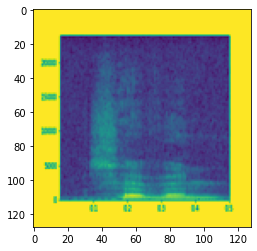

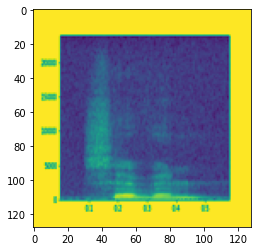

(64, 10)
(64,)
[0 5 5 0 0 5 5 0 0 9 9 5 0 5 5 0 5 5 5 5 5 5 5 5 1 5 5 5 5 5]
---
[0 5 5 5 0 5 5 1 5 9 9 5 0 5 5 0 5 5 5 5 0 5 5 5 1 5 5 5 0 5]
---
0.33972267526682004
0.2615801728513168
0.3774662497414204


In [9]:
for input1, input2 in test_dataset:
    plt.imshow(input1[3].numpy().reshape(128, 128))
    plt.show()

    plt.imshow(input2[3].numpy().reshape(128, 128))
    plt.show()
    pred1 = model(input1, training=False)
    pred2 = model(input2, training=False)
    print(pred1.shape)
    # loss_ = tf_unif_prior_crossentropy(pred1, pred2)
    # valid_loss.append(loss_)
    pred1 = pred1.numpy().argmax(axis=1)
    pred2 = pred2.numpy().argmax(axis=1)
    print(pred1.shape)
    # print(Y_test.shape)
    print(pred1[:30])
    print("---")
    print(pred2[:30])
    print("---")
    # print(str(true_label[:30]))
    # print(skl.metrics.normalized_mutual_info_score(true_label, pred1))
    # print(skl.metrics.normalized_mutual_info_score(true_label, pred2))
    print(skl.metrics.normalized_mutual_info_score(pred1, pred2))
    print(skl.metrics.adjusted_mutual_info_score(pred1, pred2))
    print(skl.metrics.adjusted_rand_score(pred1, pred2))
    # print(skl.metrics.accuracy_score(true_label, pred1))
    # print(skl.metrics.accuracy_score(true_label, pred2))
    cor_cnt = 0
    for tmp1, tmp2 in zip(pred1, pred2):
      if (tmp1 == tmp2):
        cor_cnt += 1
    break

## Only see above code!!!

In [2]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

In [ ]:
def plot_spec(data:np.array,sr:int,title:str, fpath:str) -> None:
  '''
  Function for plotting spectrogram along with amplitude wave graph
  '''
  label = str(fpath).split('/')[-1].split('_')[0]
  fig, ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].title.set_text(f'{title} / Label: {label}')
  ax[0].specgram(data,Fs=2)
  ax[1].set_ylabel('Amplitude')
  ax[1].plot(np.linspace(0,1,len(data)), data)
  

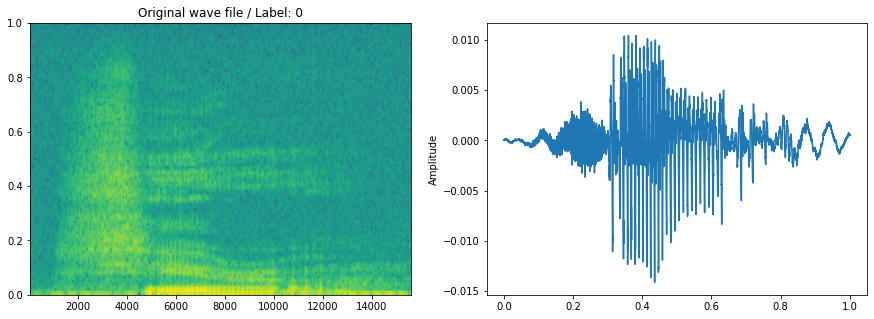

In [ ]:
file_path = 'AudioMNIST/data/01/0_01_1.wav'
wav, sr = librosa.load(file_path, sr=None)
plot_spec(wav,sr,'Original wave file',file_path)
Audio(data=wav, rate=sr)

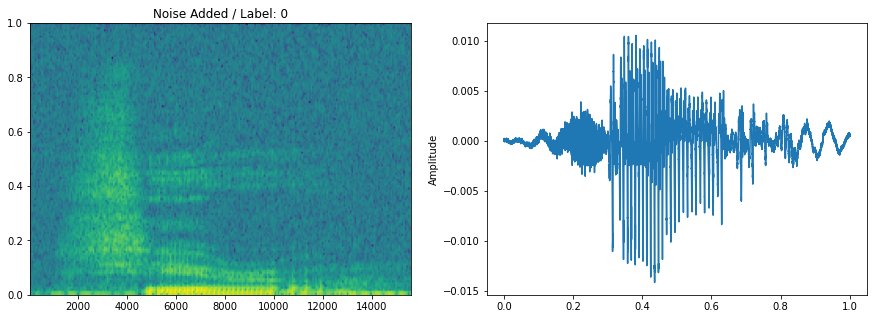

In [ ]:
'''
Noise addition using normal distribution with mean = 0 and std =1
Permissible noise factor value = x > 0.004
'''
wav_n = wav + np.random.uniform(high=0.0004) * np.random.normal(0,1,len(wav))
plot_spec(wav_n,sr,'Noise Added',file_path)
Audio(data=wav_n,rate=sr)

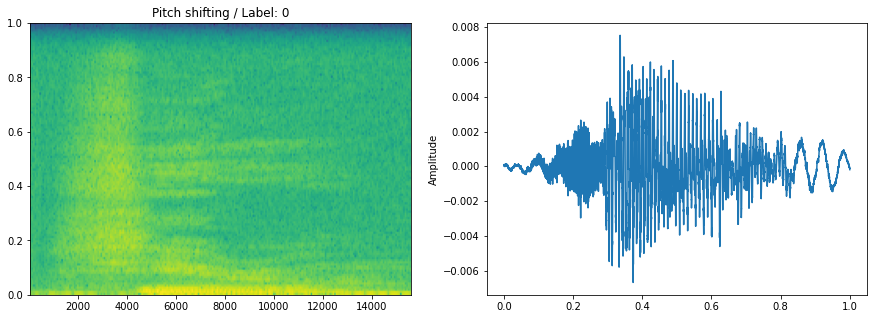

In [ ]:
#pitch shifting of wav
'''
Permissible factor values = -3 <= x <= 3
'''
wav_pitch_sf = librosa.effects.pitch_shift(wav,sr,n_steps=np.random.randint(-3, 4))
plot_spec(data=wav_pitch_sf,sr=sr,title=f'Pitch shifting',fpath=file_path)
Audio(wav_pitch_sf,rate=sr)

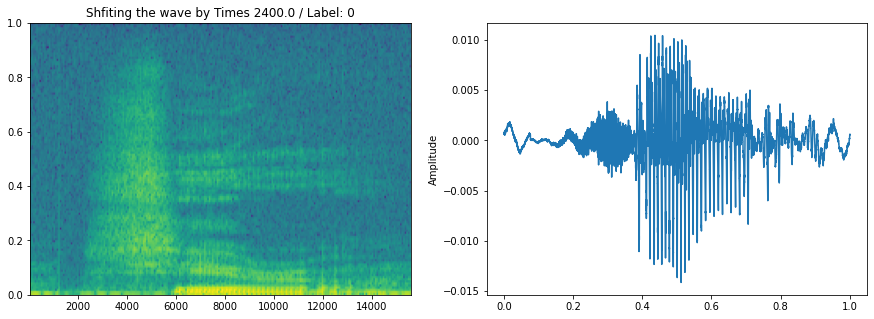

In [ ]:
'''
Permissible factor values = sr/20
'''

wav_roll = np.roll(wav,int(sr/20))
plot_spec(data=wav_roll,sr=sr,title=f'Shfiting the wave by Times {sr/20}',fpath=file_path)
Audio(wav_roll,rate=sr)

In [4]:
import soundfile as sf

def audio_augmentation(ori_filename, new_filename):
  # print(ori_filename)
  wav, sr = librosa.load(ori_filename, sr=None)
  wav_n = wav + np.random.uniform(high=0.0005) * np.random.normal(0,1,len(wav))
  wav_pitch_sf = librosa.effects.pitch_shift(wav_n,sr,n_steps=np.random.randint(-5, 6))
  wav_roll = np.roll(wav_pitch_sf,int(sr/10))
  sf.write(new_filename, wav, sr)



In [ ]:
file_path = 'AudioMNIST/data/01/0_01_1.wav'
file_new_path = 'AudioMNIST/data/01/0_01_1_re.wav'

audio_augmentation(file_path, file_new_path)


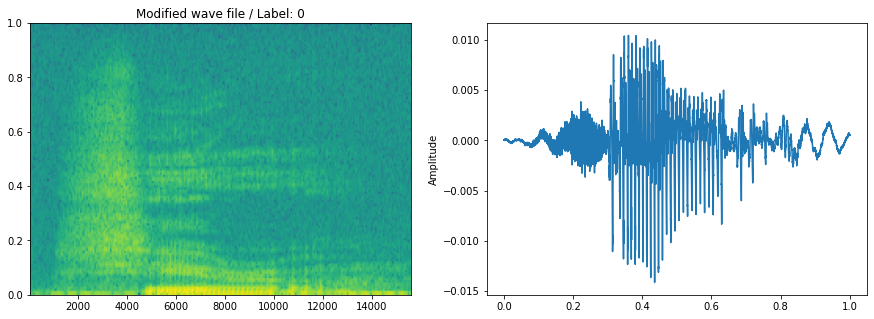

In [ ]:
wav, sr = librosa.load(file_new_path, sr=None)
plot_spec(wav,sr,'Modified wave file',file_new_path)
Audio(wav_pitch_sf,rate=sr)

In [4]:
def get_ori_name_list(name):
  ori_name_list = []
  INPUT_DIR = 'AudioMNIST/data/' + str(name).zfill(2)
  print(name)
  for filename in os.listdir(INPUT_DIR):
    if ("wav" in filename) and (not "re.wav" in filename):
      # print("here")
      ori_name_list.append(os.path.join(INPUT_DIR, filename))  
  cnt = 0

  for ori_wav in ori_name_list:
    cnt += 1
    audio_augmentation(ori_wav, ori_wav.split('.wav')[0] + 're.wav')
    if (cnt % 100 == 0):
      print("finished 100 for name " + str(name))

# for name in range(1, 5):
#   ori_name_list = []
#   INPUT_DIR = 'AudioMNIST/data/' + str(name).zfill(2)
#   print(name)
#   for filename in tqdm(os.listdir(INPUT_DIR)):
#     if ("wav" in filename) and (not "re.wav" in filename):
#       # print("here")
#       ori_name_list.append(os.path.join(INPUT_DIR, filename))  
#   cnt = 0

#   for ori_wav in tqdm(ori_name_list):
#     audio_augmentation(ori_wav, ori_wav.split('.wav')[0] + 're.wav')


In [5]:
multiprocessing.cpu_count()


2

In [6]:
pool=multiprocessing.Pool(processes=10)
# _=pool.starmap(audio_augmentation, [(ori_wav, ori_wav.split('.wav')[0] + 're.wav') for ori_wav in ori_name_list])
_ = pool.map(get_ori_name_list, list(range(1, 20)))

# for ori_wav in tqdm(ori_name_list):
  # audio_augmentation(ori_wav, ori_wav.split('.wav')[0] + 're.wav')

3810952647



1





finished 100 for name 7
finished 100 for name 8
finished 100 for name 3
finished 100 for name 4
finished 100 for name 5
finished 100 for name 1
finished 100 for name 6
finished 100 for name 10
finished 100 for name 2
finished 100 for name 9
finished 100 for name 7
finished 100 for name 8
finished 100 for name 3
finished 100 for name 5
finished 100 for name 1
finished 100 for name 4
finished 100 for name 6
finished 100 for name 2
finished 100 for name 10
finished 100 for name 9
finished 100 for name 7
finished 100 for name 8


Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-1:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


11

  File "/usr/local/lib/python3.8/dist-packages/librosa/effects.py", line 322, in pitch_shift
    y_shift = core.resample(
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.8/dist-packages/resampy/core.py", line 168, in resample
    resample_f_s(
  File "/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py", line 604, in resample
    y_hat = resampy.resample(y, orig_sr, target_sr, filter=res_type, axis=-1)


  File "/usr/local/lib/python3.8/dist-packages/numba/np/ufunc/gufunc.py", line 192, in __call__
    return self.ufunc(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/resampy/core.py", line 168, in resample
    resample_f_s(
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.8/dist-packages/numba/np/ufunc/gufunc.py", line 192, in __call__
    return self.ufunc(*args, **kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
KeyboardInterrupt
  File "<ipython-input-4-4b640517b686>", line 13, in get_ori_name_list
    audio_augmentation(ori_wav, ori_wav.split('.wav')[0] + 're.wav')
  File "<ipython-input-3-aa58a168f27c>", line 7, in audio_augmentation
    wav_pitch_sf = librosa.effects.pitch_shi

12


  File "/usr/local/lib/python3.8/dist-packages/resampy/core.py", line 168, in resample
    resample_f_s(
Process ForkPoolWorker-4:
  File "/usr/local/lib/python3.8/dist-packages/numba/np/ufunc/gufunc.py", line 192, in __call__
    return self.ufunc(*args, **kwargs)
Traceback (most recent call last):
KeyboardInterrupt


13

  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))


14

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))


  File "<ipython-input-4-4b640517b686>", line 13, in get_ori_name_list
    audio_augmentation(ori_wav, ori_wav.split('.wav')[0] + 're.wav')
  File "<ipython-input-3-aa58a168f27c>", line 7, in audio_augmentation
    wav_pitch_sf = librosa.effects.pitch_shift(wav_n,sr,n_steps=np.random.randint(-5, 6))


15

  File "/usr/local/lib/python3.8/dist-packages/librosa/effects.py", line 322, in pitch_shift
    y_shift = core.resample(
  File "/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py", line 604, in resample
    y_hat = resampy.resample(y, orig_sr, target_sr, filter=res_type, axis=-1)


  File "/usr/local/lib/python3.8/dist-packages/resampy/core.py", line 168, in resample
    resample_f_s(
  File "/usr/local/lib/python3.8/dist-packages/numba/np/ufunc/gufunc.py", line 192, in __call__
    return self.ufunc(*args, **kwargs)


16

KeyboardInterrupt



17
18
19


KeyboardInterrupt: ignored

In [ ]:
!rm -rf audio-images/
!rm -rf audio-resized-images/

In [ ]:
# generate original spec from audio
if not os.path.exists('audio-images'):
    os.mkdir('audio-images')


# def get_ori_spec(name):
for name in range(1, 20):
  INPUT_DIR = 'AudioMNIST/data/' + str(name).zfill(2)
  print(name)
  cnt = 0
  for filename in tqdm(os.listdir(INPUT_DIR)):
    if "wav" in filename:
      cnt += 1
      file_path = os.path.join(INPUT_DIR, filename)
      # if (cnt % 100 == 0):
        # print("finished 100 for name " + str(name))
      file_stem = Path(file_path).stem
      target_dir = f'class_{file_stem[0]}'
      dist_dir = os.path.join('audio-images', target_dir)
      file_dist_path = os.path.join(dist_dir, file_stem)
      if not os.path.exists(file_dist_path + '.png'):
          if not os.path.exists(dist_dir):
              os.mkdir(dist_dir)
          file_stem = Path(file_path).stem
          sound_info, frame_rate = get_wav_info(file_path)
          pylab.specgram(sound_info, Fs=frame_rate)
          pylab.savefig(f'{file_dist_path}.png')
          pylab.close()

1


100%|██████████| 500/500 [01:11<00:00,  6.96it/s]


2


100%|██████████| 500/500 [01:10<00:00,  7.09it/s]


3


100%|██████████| 500/500 [01:08<00:00,  7.33it/s]


4


100%|██████████| 500/500 [01:09<00:00,  7.18it/s]


5


100%|██████████| 500/500 [01:08<00:00,  7.25it/s]


6


100%|██████████| 500/500 [01:09<00:00,  7.18it/s]


7


100%|██████████| 500/500 [01:11<00:00,  6.96it/s]


8


100%|██████████| 500/500 [01:05<00:00,  7.60it/s]


9


100%|██████████| 500/500 [01:09<00:00,  7.17it/s]


10


100%|██████████| 500/500 [01:06<00:00,  7.47it/s]


11


100%|██████████| 500/500 [01:12<00:00,  6.94it/s]


12


100%|██████████| 500/500 [01:06<00:00,  7.54it/s]


13


100%|██████████| 500/500 [01:14<00:00,  6.73it/s]


14


100%|██████████| 500/500 [01:06<00:00,  7.52it/s]


15


100%|██████████| 500/500 [01:06<00:00,  7.49it/s]


16


100%|██████████| 500/500 [01:13<00:00,  6.84it/s]


17


100%|██████████| 500/500 [01:09<00:00,  7.20it/s]


18


 71%|███████   | 354/500 [00:47<00:20,  7.22it/s]

In [ ]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory='audio-images',
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory='audio-images',
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 3744 files belonging to 10 classes.
Using 2996 files for training.
Found 3744 files belonging to 10 classes.
Using 748 files for validation.


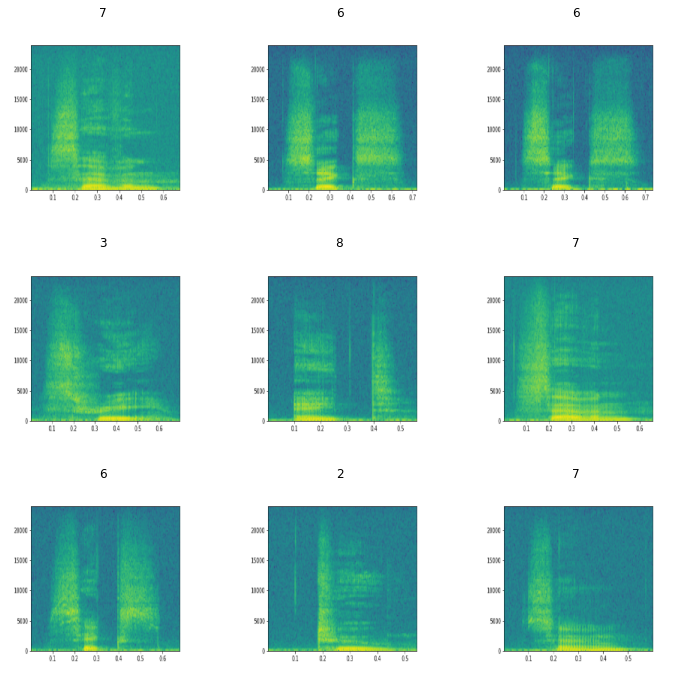

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [80]:
!rm -rf audio-resized-images/

In [81]:
# Change image size to 64 * 64
if not os.path.exists('audio-resized-images'):
    os.mkdir('audio-resized-images')

for filename in tqdm(glob.glob(r'audio-images' + '/**/*.png', recursive=True)):
    file_stem = Path(filename).stem
    target_dir = f'class_{file_stem[0]}'
    dist_dir = os.path.join('audio-resized-images', target_dir)
    file_dist_path = os.path.join(dist_dir, file_stem)

    if not os.path.exists(file_dist_path + '.png'):
        if not os.path.exists(dist_dir):
            os.mkdir(dist_dir)
        im = Image.open(filename)
        try:
          imm = im.resize((64, 64))
          imm.save(file_dist_path + '.png')
          im.close
          imm.close
        except:
          print(filename)


100%|██████████| 8854/8854 [01:12<00:00, 121.37it/s]


In [1]:
import numpy as np
import tensorflow as tf
import scipy as scp
import sklearn as skl
from tqdm import tqdm
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import sklearn.metrics
from PIL import Image
import glob
import os
from tqdm import tqdm
import wave
import pylab
from pathlib import Path
import librosa
from IPython.display import Audio
import multiprocessing


In [121]:
image_list_ori = []
image_list_re = []

for filename in tqdm(glob.glob(r'audio-resized-images/' + '/**/*.png', recursive=True)):
  if '.png' in filename:
    # print(filename)
    # ori_name1 = filename.split('re.png')[0] + '.png'
    ori_name1 = filename
    # print(ori_name1)
    file_stem = Path(ori_name1).stem
    # print(file_stem)
    ori_name2 = ori_name1.rsplit('_', 2)[0] + '_' + str((int(file_stem.split('_')[1]) + 10) % 19) \
                      + "_" + str((int(file_stem.split('_')[-1]) + 15) % 60) + ".png"
    # print(ori_name2)
    if (os.path.exists(ori_name1) and os.path.exists(ori_name2)):
      im = Image.open(ori_name2).convert('RGB')
      image_list_re.append(np.asarray(im))
      im.close
      im = Image.open(ori_name1).convert('RGB')
      image_list_ori.append(np.asarray(im))
      im.close
    # break
    

100%|██████████| 8854/8854 [00:02<00:00, 4065.07it/s]


In [109]:
image_list_ori = np.array(image_list_ori)
image_list_re = np.array(image_list_re)

In [110]:
image_list_ori.shape

(3086, 64, 64, 3)

In [122]:
aug = iaa.Grayscale(alpha=(0.0, 1.0))
def def_augment(images, n=2, m=3):
    #
    rand_aug = iaa.RandAugment(n=n, m=m)
    
    #     @tf.numpy_function
    # def augment(images):
    #     # Input to `augment()` is a TensorFlow tensor which
    #     # is not supported by `imgaug`. This is why we first
    #     # convert it to its `numpy` variant.
    #     print(images.shape)
    #     images = aug(images=images)
    #     return rand_aug(images=images).reshape(-1,784)

    images = aug(images=images)
    return rand_aug(images=images)

In [123]:
image_list_re = def_augment(image_list_ori)

In [124]:
image_list_re2 = def_augment(image_list_ori)

In [125]:
image_list_ori = image_list_re2

In [126]:
# import random

# both_list = list(zip(image_list_ori, image_list_re))

# random.shuffle(both_list) # This line now has shuffled your list(inplace operation)

# image_list_ori, image_list_re = zip(*both_list)
n = len(image_list_ori)
train_data_len = int(n*0.8) # Roughly 50k images
train_data_1 = image_list_ori[:train_data_len] # getting images upto 50k index
test_data_1 = image_list_ori[train_data_len:] # getting rest of the images
train_data_2 = image_list_re[:train_data_len] # getting images upto 50k index
test_data_2 = image_list_re[train_data_len:] # getting rest of the images

In [127]:
train_data_1 = np.array(train_data_1)[:, :, :, 1]
test_data_1 = np.array(test_data_1)[:, :, :, 1]
train_data_2 = np.array(train_data_2)[:, :, :, 1]
test_data_2 = np.array(test_data_2)[:, :, :, 1]

In [128]:
train_data_1.shape

(2468, 64, 64)

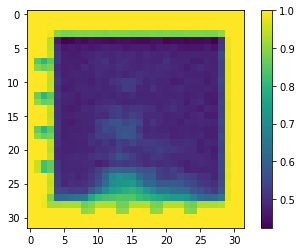

In [79]:
plt.imshow(train_data_1.reshape(-1, 32, 32)[1000][ :, :])
plt.colorbar()

plt.show()

In [129]:
train_data_1 = train_data_1.reshape(-1, 4096).astype("float32") / 255.0
test_data_1 = test_data_1.reshape(-1, 4096).astype("float32") / 255.0
train_data_2 = train_data_2.reshape(-1, 4096).astype("float32") / 255.0
test_data_2 = test_data_2.reshape(-1, 4096).astype("float32") / 255.0

# train_data_1 = train_data_1.astype("float32") / 255.0
# test_data_1 = test_data_1.astype("float32") / 255.0
# train_data_2 = train_data_2.astype("float32") / 255.0
# test_data_2 = test_data_2.astype("float32") / 255.0

In [130]:
def tf_unif_prior_crossentropy(pred1,pred2):
    N, C = pred1.shape 
    t_c = 0.1
    t_r = 0.1
    a = tf.nn.softmax(pred2/t_c, axis=0)
    b = tf.linalg.norm(a, ord=1,axis=1)
    # try :
    c = a/tf.reshape(b,(N,-1))
    # except :
    #     try :
    #         c = a/tf.reshape(b,(X_train.shape[0]%batch_size,-1))
    #     except :
    #         c = a/tf.reshape(b,(X_test.shape[0]%batch_size,-1))
            

    part11 = c
    d = tf.nn.softmax(pred1/t_r, axis=1)
    part21 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)), (-1,C))
    loss_1 = -tf.math.reduce_sum( part11 * part21 , axis=-1)


    a = tf.nn.softmax(pred1/t_c)
    b = tf.linalg.norm(a, ord=1,axis=1)
    c = a/tf.reshape(b,(N,-1))
    part12 = c
    d = tf.nn.softmax(pred2/t_r, axis=1)
    part22 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)),(-1,C))
    loss_2 = -tf.math.reduce_sum( part12*part22 , axis=-1)

    return tf.math.reduce_mean(1/2*(loss_1+loss_2))

In [136]:

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(32, 32, 3), dtype=tf.float32),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(10,activation = 'softmax', dtype='float32'),
#     ])


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64 * 64), dtype=tf.float32),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10,activation = None, dtype='float32'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("softmax")
    ])

model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 32)                131104    
                                                                 
 batch_normalization_44 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 32)                0         
                                                                 
 dense_69 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_45 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_37 (Dropout)        (None, 64)              

In [137]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

NUM_EPOCHS = 100
EPOCH_PER_DISPLAY = 1
total_loss = []
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_1, train_data_2))
train_dataset = train_dataset.shuffle(train_data_1.shape[0]).batch(1000)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_1, test_data_2))
test_dataset = test_dataset.shuffle(test_data_1.shape[0]).batch(200)

for epoch in range(NUM_EPOCHS):

  running_loss = []

  for input1, input2 in tqdm(train_dataset):
    with tf.GradientTape() as tape:

      pred1 = model(input1, training=True)
      pred2 = model(input2, training=True)

      loss_ = tf_unif_prior_crossentropy(pred1, pred2)

      grads = tape.gradient(loss_, model.trainable_variables)
      
    running_loss.append(loss_)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
  
  epoch_loss = np.mean(running_loss)
  if (epoch + 1) % EPOCH_PER_DISPLAY == 0:
    print("Epoch {}: Train Loss: {:.4f}".format(epoch+1, epoch_loss), end="")


  valid_loss = []
  valid_nmi = []
  valid_ami = []
  valid_ari = []
  valid_acc = []

  for input1, input2 in test_dataset:
    pred1 = model(input1, training=False)
    pred2 = model(input2, training=False)
    loss_ = tf_unif_prior_crossentropy(pred1, pred2)
    valid_loss.append(loss_)
    pred1 = pred1.numpy().argmax(axis=1)
    pred2 = pred2.numpy().argmax(axis=1)
    valid_nmi.append(skl.metrics.normalized_mutual_info_score(pred1, pred2))
    valid_ami.append(skl.metrics.adjusted_mutual_info_score(pred1, pred2))
    valid_ari.append(skl.metrics.adjusted_rand_score(pred1, pred2))
    valid_acc.append(skl.metrics.accuracy_score(pred1, pred2))
    cor_cnt = 0
    for tmp1, tmp2 in zip(pred1, pred2):
      if (tmp1 == tmp2):
        cor_cnt += 1
  print("   Valid Loss: {:.4f}    NMI: {:.4f}   AMI: {:.4f}   ARI: {:.4f}   ACC: {:.4f}".format(np.mean(valid_loss), 
                                                                                np.mean(valid_nmi), np.mean(valid_ami), 
                                                                                np.mean(valid_ari), np.mean(valid_acc), cor_cnt))

100%|██████████| 3/3 [00:00<00:00,  8.40it/s]


Epoch 1: Train Loss: 2.8775   Valid Loss: 2.3133    NMI: 0.0560   AMI: 0.0309   ARI: 0.1169   ACC: 0.7685


100%|██████████| 3/3 [00:00<00:00, 13.92it/s]


Epoch 2: Train Loss: 2.8618   Valid Loss: 2.3140    NMI: 0.0096   AMI: -0.0079   ARI: 0.0293   ACC: 0.8786


100%|██████████| 3/3 [00:00<00:00, 12.25it/s]


Epoch 3: Train Loss: 2.8616   Valid Loss: 2.3144    NMI: 0.2712   AMI: 0.2362   ARI: 0.2323   ACC: 0.8838


100%|██████████| 3/3 [00:00<00:00, 13.92it/s]


Epoch 4: Train Loss: 2.8451   Valid Loss: 2.3186    NMI: 0.1355   AMI: 0.0754   ARI: 0.0500   ACC: 0.7746


100%|██████████| 3/3 [00:00<00:00, 14.65it/s]


Epoch 5: Train Loss: 2.8467   Valid Loss: 2.3242    NMI: 0.0476   AMI: -0.0380   ARI: -0.0549   ACC: 0.7042


100%|██████████| 3/3 [00:00<00:00, 13.08it/s]


Epoch 6: Train Loss: 2.8252   Valid Loss: 2.3214    NMI: 0.0364   AMI: 0.0050   ARI: 0.0273   ACC: 0.7208


100%|██████████| 3/3 [00:00<00:00, 13.67it/s]


Epoch 7: Train Loss: 2.8260   Valid Loss: 2.3237    NMI: 0.0249   AMI: -0.0022   ARI: 0.0235   ACC: 0.7133


100%|██████████| 3/3 [00:00<00:00, 14.32it/s]


Epoch 8: Train Loss: 2.8119   Valid Loss: 2.3255    NMI: 0.0286   AMI: -0.0188   ARI: 0.0074   ACC: 0.6994


100%|██████████| 3/3 [00:00<00:00, 14.04it/s]


Epoch 9: Train Loss: 2.8087   Valid Loss: 2.3238    NMI: 0.1016   AMI: 0.0548   ARI: 0.1012   ACC: 0.6994


100%|██████████| 3/3 [00:00<00:00, 14.23it/s]


Epoch 10: Train Loss: 2.8055   Valid Loss: 2.3306    NMI: 0.0419   AMI: 0.0012   ARI: 0.0045   ACC: 0.6603


100%|██████████| 3/3 [00:00<00:00, 13.89it/s]


Epoch 11: Train Loss: 2.8190   Valid Loss: 2.3313    NMI: 0.0398   AMI: 0.0107   ARI: -0.0034   ACC: 0.6578


100%|██████████| 3/3 [00:00<00:00, 14.30it/s]


Epoch 12: Train Loss: 2.7995   Valid Loss: 2.3285    NMI: 0.0343   AMI: 0.0088   ARI: 0.0720   ACC: 0.6969


100%|██████████| 3/3 [00:00<00:00, 14.07it/s]


Epoch 13: Train Loss: 2.8208   Valid Loss: 2.3329    NMI: 0.0279   AMI: 0.0008   ARI: 0.0390   ACC: 0.6603


100%|██████████| 3/3 [00:00<00:00, 14.16it/s]


Epoch 14: Train Loss: 2.7940   Valid Loss: 2.3331    NMI: 0.0262   AMI: -0.0062   ARI: 0.0462   ACC: 0.6692


100%|██████████| 3/3 [00:00<00:00, 13.16it/s]


Epoch 15: Train Loss: 2.7755   Valid Loss: 2.3329    NMI: 0.0542   AMI: 0.0239   ARI: 0.0863   ACC: 0.6794


100%|██████████| 3/3 [00:00<00:00, 13.59it/s]


Epoch 16: Train Loss: 2.7970   Valid Loss: 2.3388    NMI: 0.0525   AMI: 0.0177   ARI: 0.0028   ACC: 0.6189


100%|██████████| 3/3 [00:00<00:00, 14.01it/s]


Epoch 17: Train Loss: 2.7729   Valid Loss: 2.3349    NMI: 0.0953   AMI: 0.0378   ARI: 0.0902   ACC: 0.6292


100%|██████████| 3/3 [00:00<00:00, 14.23it/s]


Epoch 18: Train Loss: 2.7730   Valid Loss: 2.3397    NMI: 0.0451   AMI: -0.0240   ARI: -0.0012   ACC: 0.5410


100%|██████████| 3/3 [00:00<00:00,  9.88it/s]


Epoch 19: Train Loss: 2.7771   Valid Loss: 2.3392    NMI: 0.0780   AMI: -0.0072   ARI: 0.0161   ACC: 0.5325


100%|██████████| 3/3 [00:00<00:00, 14.02it/s]


Epoch 20: Train Loss: 2.7778   Valid Loss: 2.3371    NMI: 0.0878   AMI: -0.0173   ARI: -0.0029   ACC: 0.4650


100%|██████████| 3/3 [00:00<00:00, 14.27it/s]


Epoch 21: Train Loss: 2.7853   Valid Loss: 2.3390    NMI: 0.0651   AMI: -0.0307   ARI: -0.0048   ACC: 0.4147


100%|██████████| 3/3 [00:00<00:00, 13.77it/s]


Epoch 22: Train Loss: 2.7918   Valid Loss: 2.3418    NMI: 0.1170   AMI: 0.0139   ARI: 0.0180   ACC: 0.3571


100%|██████████| 3/3 [00:00<00:00, 14.12it/s]


Epoch 23: Train Loss: 2.7511   Valid Loss: 2.3426    NMI: 0.1171   AMI: 0.0121   ARI: 0.0039   ACC: 0.3485


100%|██████████| 3/3 [00:00<00:00, 13.66it/s]


Epoch 24: Train Loss: 2.7829   Valid Loss: 2.3462    NMI: 0.1225   AMI: 0.0213   ARI: 0.0124   ACC: 0.3561


100%|██████████| 3/3 [00:00<00:00, 13.36it/s]


Epoch 25: Train Loss: 2.7605   Valid Loss: 2.3557    NMI: 0.1008   AMI: -0.0093   ARI: -0.0037   ACC: 0.3083


100%|██████████| 3/3 [00:00<00:00, 14.14it/s]


Epoch 26: Train Loss: 2.7583   Valid Loss: 2.3512    NMI: 0.0852   AMI: -0.0011   ARI: -0.0127   ACC: 0.3160


100%|██████████| 3/3 [00:00<00:00, 14.49it/s]


Epoch 27: Train Loss: 2.7788   Valid Loss: 2.3455    NMI: 0.1583   AMI: 0.0629   ARI: 0.0320   ACC: 0.3110


100%|██████████| 3/3 [00:00<00:00, 13.99it/s]


Epoch 28: Train Loss: 2.7631   Valid Loss: 2.3560    NMI: 0.1296   AMI: 0.0215   ARI: 0.0159   ACC: 0.2946


100%|██████████| 3/3 [00:00<00:00, 14.56it/s]


Epoch 29: Train Loss: 2.7592   Valid Loss: 2.3587    NMI: 0.1204   AMI: 0.0043   ARI: -0.0040   ACC: 0.2692


100%|██████████| 3/3 [00:00<00:00, 14.27it/s]


Epoch 30: Train Loss: 2.7437   Valid Loss: 2.3657    NMI: 0.1191   AMI: 0.0064   ARI: 0.0155   ACC: 0.3021


100%|██████████| 3/3 [00:00<00:00, 14.64it/s]


Epoch 31: Train Loss: 2.7395   Valid Loss: 2.3684    NMI: 0.1123   AMI: -0.0193   ARI: -0.0112   ACC: 0.2793


100%|██████████| 3/3 [00:00<00:00, 13.29it/s]


Epoch 32: Train Loss: 2.7572   Valid Loss: 2.3578    NMI: 0.1705   AMI: 0.0633   ARI: 0.0622   ACC: 0.2793


100%|██████████| 3/3 [00:00<00:00, 14.47it/s]


Epoch 33: Train Loss: 2.7580   Valid Loss: 2.3683    NMI: 0.1797   AMI: 0.0411   ARI: 0.0684   ACC: 0.3147


100%|██████████| 3/3 [00:00<00:00, 14.13it/s]


Epoch 34: Train Loss: 2.7568   Valid Loss: 2.3737    NMI: 0.1394   AMI: 0.0039   ARI: 0.0137   ACC: 0.2718


100%|██████████| 3/3 [00:00<00:00, 13.70it/s]


Epoch 35: Train Loss: 2.7396   Valid Loss: 2.3871    NMI: 0.1217   AMI: -0.0127   ARI: 0.0083   ACC: 0.2946


100%|██████████| 3/3 [00:00<00:00, 14.44it/s]


Epoch 36: Train Loss: 2.7652   Valid Loss: 2.3729    NMI: 0.1164   AMI: 0.0030   ARI: 0.0103   ACC: 0.3097


100%|██████████| 3/3 [00:00<00:00, 14.33it/s]


Epoch 37: Train Loss: 2.7346   Valid Loss: 2.3743    NMI: 0.1787   AMI: 0.0521   ARI: 0.0826   ACC: 0.3022


100%|██████████| 3/3 [00:00<00:00, 11.99it/s]


Epoch 38: Train Loss: 2.7405   Valid Loss: 2.3828    NMI: 0.1499   AMI: 0.0050   ARI: 0.0223   ACC: 0.2669


100%|██████████| 3/3 [00:00<00:00, 13.63it/s]


Epoch 39: Train Loss: 2.7405   Valid Loss: 2.3807    NMI: 0.1168   AMI: -0.0196   ARI: 0.0020   ACC: 0.2406


100%|██████████| 3/3 [00:00<00:00, 13.75it/s]


Epoch 40: Train Loss: 2.7378   Valid Loss: 2.3998    NMI: 0.1347   AMI: -0.0163   ARI: 0.0008   ACC: 0.2179


100%|██████████| 3/3 [00:00<00:00, 12.96it/s]


Epoch 41: Train Loss: 2.7353   Valid Loss: 2.3970    NMI: 0.1174   AMI: -0.0588   ARI: -0.0280   ACC: 0.2179


100%|██████████| 3/3 [00:00<00:00, 14.09it/s]


Epoch 42: Train Loss: 2.7541   Valid Loss: 2.4016    NMI: 0.1601   AMI: 0.0148   ARI: 0.0198   ACC: 0.2382


100%|██████████| 3/3 [00:00<00:00, 14.18it/s]


Epoch 43: Train Loss: 2.7221   Valid Loss: 2.3982    NMI: 0.1257   AMI: -0.0283   ARI: -0.0181   ACC: 0.2243


100%|██████████| 3/3 [00:00<00:00, 14.18it/s]


Epoch 44: Train Loss: 2.7423   Valid Loss: 2.4064    NMI: 0.1511   AMI: -0.0046   ARI: 0.0011   ACC: 0.2104


100%|██████████| 3/3 [00:00<00:00, 13.77it/s]


Epoch 45: Train Loss: 2.7220   Valid Loss: 2.4228    NMI: 0.1306   AMI: -0.0376   ARI: -0.0169   ACC: 0.2003


100%|██████████| 3/3 [00:00<00:00, 13.85it/s]


Epoch 46: Train Loss: 2.7396   Valid Loss: 2.4147    NMI: 0.1596   AMI: 0.0006   ARI: 0.0038   ACC: 0.2104


100%|██████████| 3/3 [00:00<00:00, 13.14it/s]


Epoch 47: Train Loss: 2.7287   Valid Loss: 2.4130    NMI: 0.1510   AMI: -0.0104   ARI: 0.0067   ACC: 0.2421


100%|██████████| 3/3 [00:00<00:00, 14.04it/s]


Epoch 48: Train Loss: 2.7304   Valid Loss: 2.4198    NMI: 0.1431   AMI: -0.0208   ARI: -0.0132   ACC: 0.1979


100%|██████████| 3/3 [00:00<00:00, 14.17it/s]


Epoch 49: Train Loss: 2.7337   Valid Loss: 2.4238    NMI: 0.1370   AMI: -0.0051   ARI: -0.0042   ACC: 0.2054


100%|██████████| 3/3 [00:00<00:00, 13.06it/s]


Epoch 50: Train Loss: 2.7310   Valid Loss: 2.4186    NMI: 0.1649   AMI: -0.0147   ARI: -0.0013   ACC: 0.1790


100%|██████████| 3/3 [00:00<00:00, 13.83it/s]


Epoch 51: Train Loss: 2.7356   Valid Loss: 2.4284    NMI: 0.1460   AMI: -0.0607   ARI: -0.0373   ACC: 0.1879


100%|██████████| 3/3 [00:00<00:00, 13.88it/s]


Epoch 52: Train Loss: 2.7353   Valid Loss: 2.4304    NMI: 0.1876   AMI: 0.0306   ARI: 0.0271   ACC: 0.1892


100%|██████████| 3/3 [00:00<00:00, 13.83it/s]


Epoch 53: Train Loss: 2.7337   Valid Loss: 2.4163    NMI: 0.1776   AMI: 0.0540   ARI: 0.0448   ACC: 0.1931


100%|██████████| 3/3 [00:00<00:00, 12.42it/s]


Epoch 54: Train Loss: 2.7240   Valid Loss: 2.4318    NMI: 0.1695   AMI: -0.0163   ARI: -0.0107   ACC: 0.1653


100%|██████████| 3/3 [00:00<00:00,  9.91it/s]


Epoch 55: Train Loss: 2.7090   Valid Loss: 2.4469    NMI: 0.1679   AMI: -0.0045   ARI: 0.0027   ACC: 0.1426


100%|██████████| 3/3 [00:00<00:00, 10.93it/s]


Epoch 56: Train Loss: 2.7242   Valid Loss: 2.4415    NMI: 0.1398   AMI: -0.0400   ARI: -0.0164   ACC: 0.1528


100%|██████████| 3/3 [00:00<00:00,  9.67it/s]


Epoch 57: Train Loss: 2.7180   Valid Loss: 2.4476    NMI: 0.1623   AMI: -0.0370   ARI: -0.0278   ACC: 0.1540


100%|██████████| 3/3 [00:00<00:00,  9.91it/s]


Epoch 58: Train Loss: 2.7090   Valid Loss: 2.4607    NMI: 0.1792   AMI: 0.0068   ARI: 0.0031   ACC: 0.1781


100%|██████████| 3/3 [00:00<00:00, 12.20it/s]


Epoch 59: Train Loss: 2.7110   Valid Loss: 2.4432    NMI: 0.1845   AMI: 0.0204   ARI: 0.0102   ACC: 0.1451


100%|██████████| 3/3 [00:00<00:00, 13.91it/s]


Epoch 60: Train Loss: 2.7253   Valid Loss: 2.4506    NMI: 0.1670   AMI: 0.0201   ARI: 0.0145   ACC: 0.1501


100%|██████████| 3/3 [00:00<00:00, 14.28it/s]


Epoch 61: Train Loss: 2.7333   Valid Loss: 2.4723    NMI: 0.1595   AMI: 0.0094   ARI: 0.0026   ACC: 0.1551


100%|██████████| 3/3 [00:00<00:00, 13.46it/s]


Epoch 62: Train Loss: 2.7244   Valid Loss: 2.4656    NMI: 0.1932   AMI: 0.0409   ARI: 0.0161   ACC: 0.1615


 33%|███▎      | 1/3 [00:00<00:00,  7.09it/s]


KeyboardInterrupt: ignored

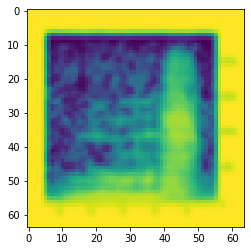

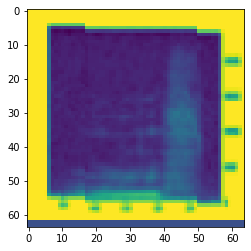

(200, 10)
(200,)
[2 6 0 4 8 6 7 8 7 2 2 2 6 6 6 2 4 6 6 8 4 4 4 8 4 2 6 8 2 2]
---
[2 6 4 2 6 4 2 4 6 4 6 2 4 6 7 4 2 6 7 6 8 7 7 2 6 2 2 4 6 6]
---
0.08400988728510218
0.014105574689226375
0.009366036482730484


In [133]:
for input1, input2 in test_dataset:
    plt.imshow(input1[3].numpy().reshape(64, 64))
    plt.show()

    plt.imshow(input2[3].numpy().reshape(64, 64))
    plt.show()
    pred1 = model(input1, training=False)
    pred2 = model(input2, training=False)
    print(pred1.shape)
    # loss_ = tf_unif_prior_crossentropy(pred1, pred2)
    # valid_loss.append(loss_)
    pred1 = pred1.numpy().argmax(axis=1)
    pred2 = pred2.numpy().argmax(axis=1)
    print(pred1.shape)
    # print(Y_test.shape)
    print(pred1[:30])
    print("---")
    print(pred2[:30])
    print("---")
    # print(str(true_label[:30]))
    # print(skl.metrics.normalized_mutual_info_score(true_label, pred1))
    # print(skl.metrics.normalized_mutual_info_score(true_label, pred2))
    print(skl.metrics.normalized_mutual_info_score(pred1, pred2))
    print(skl.metrics.adjusted_mutual_info_score(pred1, pred2))
    print(skl.metrics.adjusted_rand_score(pred1, pred2))
    # print(skl.metrics.accuracy_score(true_label, pred1))
    # print(skl.metrics.accuracy_score(true_label, pred2))
    cor_cnt = 0
    for tmp1, tmp2 in zip(pred1, pred2):
      if (tmp1 == tmp2):
        cor_cnt += 1
    break